# Assignment 5: REINFORCE on Gym's Cartpole problem

In [51]:
import math
import gym
from matplotlib import pyplot as plt
import torch
from torch import nn, optim
from torch.distributions import Categorical
from torch.nn import functional as F
from IPython.display import clear_output, display
%matplotlib inline
gym.logger.set_level(50)
import numpy as np

array([ 0.03606111,  0.02892547,  0.03696746, -0.01972753])

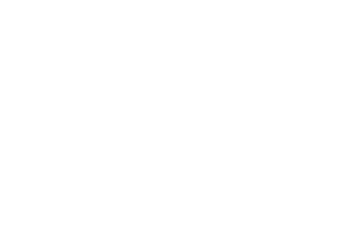

In [52]:
plt.axis('off')

env = gym.make('CartPole-v0')
env.reset()

In [53]:
print(f"state_space: {env.observation_space} \n") 
print(f"action_space: {env.action_space}")

state_space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32) 

action_space: Discrete(2)


In [54]:
def obs_to_tensor(obs):
    return torch.tensor(obs, dtype=torch.float32).unsqueeze(0)

def plot():
    plt.plot(range(len(total_rewards)), total_rewards, 'r-')
    clear_output(wait=True)
    display(plt.gcf())

In [57]:
a, b, c, d = env.step(env.action_space.sample())[0]

In [61]:
import random
def sigmoid_policy(state,theta):
    prob = 1/(1+np.exp(-1*state@theta))
    if random.random() < prob:
        return 1 # mv right
    else:
        return 0 # mv left

In [65]:
env.reset()

array([0.0316757 , 0.02220997, 0.04147368, 0.00676946])

In [88]:
0.27*180/np.pi

16.04281826366305

In [83]:
env.step(1)

(array([ 0.2592397 ,  2.35189121, -0.22748671, -3.30885765]), 1.0, True, {})

In [107]:
theta = np.array([0,0,10,2.5])

'Average reward: 197.90'

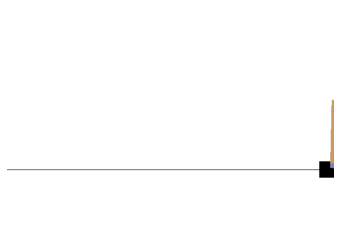

In [108]:
plt.axis('off')

env = gym.make('CartPole-v0')
env.reset()
rollouts = 100
total_reward = 0
view = plt.imshow(env.render(mode='rgb_array'))

# Perform several rollouts/episodes with a random policy
for _ in range(rollouts):
    state, done = env.reset(), False  # Reset the environment to a starting state
    while not done:  # Act until episode terminates
        view.set_data(env.render(mode='rgb_array'))
        display(plt.gcf())
        clear_output(wait=True)
        next_state, reward, done, _ = env.step(sigmoid_policy(state, theta))  # Sample random (valid) action
        total_reward += reward
        state=next_state

env.close()
display('Average reward: %.2f' % (total_reward / rollouts))

Open gym considers the problem solved if the average reward is greater than 195. Now let's use a policy gradient method to get to this solution. 

In [119]:
# instantiate random parameters
theta = np.array([(2*random.random()-1) for i in range(4)])

gradient of the sigmoid policy w.r.t. parameters:
$$\nabla_{\theta}{\log \sigma} = \frac{-s\exp{\left(-\theta^T\cdot s\right)}}{1+\exp{\left(-\theta^T\cdot s\right)}}$$

The gradient ascent step in REINFORCE looks like:
$$\theta \leftarrow \theta + \alpha \gamma G_t \nabla_{\theta}{\log \sigma} $$
where $\alpha$ is some constant (or adaptive) learning rate, $\gamma$ is a discount factor and $G_t$ is the next step returns following a sample policy path trajectory.

The REINFORCE algo in question is:

* Initialize random policy
* Generate an MDP trajectory using this.
* For t=1, ..., T:
    * Estimate $G_t$
    * Update policy paramters

In [112]:
def gls(state, theta, action):
    "gradient of the log of the sigmoid policy"
    log_grad_sigmoid = -1*state*np.exp(-1*state@theta)/(1+np.exp(-1*state@theta))
    if action == 1:
        return log_grad_sigmoid
    else:
        return -state+log_grad_sigmoid

'Average final reward: 88.80'

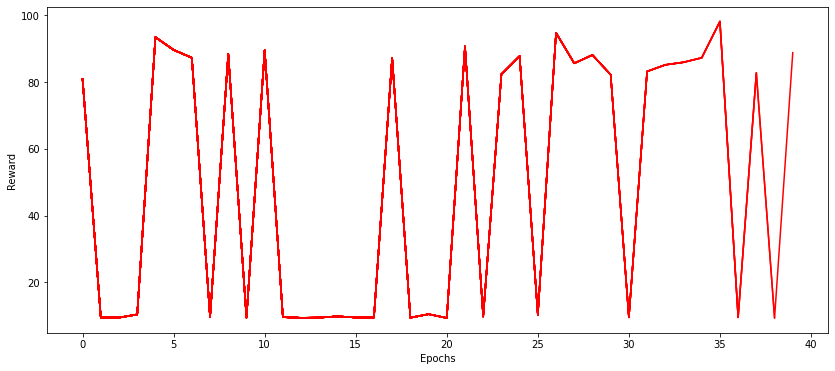

In [164]:
discount = 0.999
alpha=0.01
epochs = 40
rollouts = 200
total_rewards = []

plt.figure(figsize=(14, 6))
plt.xlabel('Epochs')
plt.ylabel('Reward')

# instantiate random parameters
theta = np.array([(2*random.random()-1) for i in range(4)])

for _ in range(epochs):
        
    total_reward = 0

    for _ in range(rollouts):
        obs, done = env.reset(), False
        log_probs_action, rewards= [], []  # Collect outputs for training

        while not done:
            # Sample an action from the policy conditioned on the current observation
            action = sigmoid_policy(obs, theta)
            
            # Take a step in the enviroment based on the action
            next_obs, reward, done, _ = env.step(action)
            total_reward += reward

            # Store outputs that will be used for training
            rewards.append(reward)
            log_probs_action.append(gls(obs, theta, action))
            obs = next_obs
            


        # Initialise the final reward and generalised advantage at 0
        ep_return = 0
        trajectory_length = len(rewards)
        
        for i in reversed(range(trajectory_length)):  # Calculate the return backwards
            ep_return = rewards[i] + discount * ep_return  # Calculate the return recursively backwards; this is G_t
            theta -= log_probs_action[i] * ep_return*alpha  # Use the generalised advantage to weight the policy gradient


    total_rewards.append(total_reward / rollouts)
    plot()

clear_output(wait=True)
display('Average final reward: %.2f' % total_rewards[-1])

In [165]:
theta

array([  37.51794602, -795.23549592,   11.25825737, 1329.48834587])

### this wasn't very successful. Now try fitting the elephant approach

In [194]:
class Agent(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 20)
        self.fc2 = nn.Linear(20, 40)
        self.head = nn.Linear(40,2)

    def forward(self, obs):
        obs = F.relu(self.fc1(obs))
        obs = F.relu(self.fc2(obs))
        policy = F.softmax(self.head(obs))
        return Categorical(logits=policy)
        

In [195]:
x = Agent()

In [196]:
np.random.random(4)

array([0.30610359, 0.18665002, 0.78078128, 0.60558534])

In [197]:
prob_dist = x(torch.rand(1,4))
p.sample()

<ipython-input-194-88b54bc72982>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  policy = F.softmax(self.head(obs))


tensor([0])

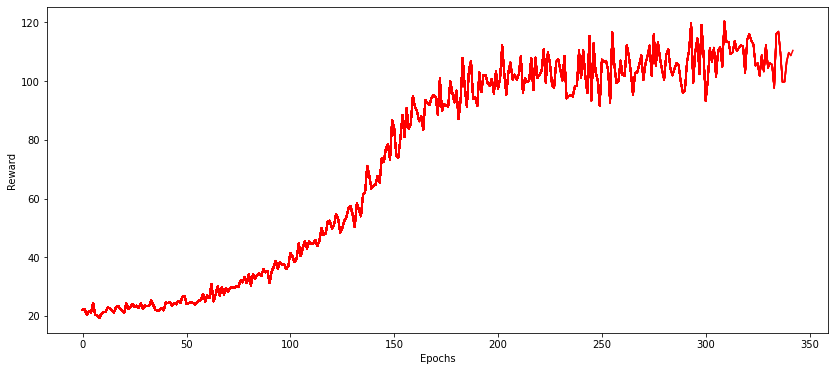

KeyboardInterrupt: 

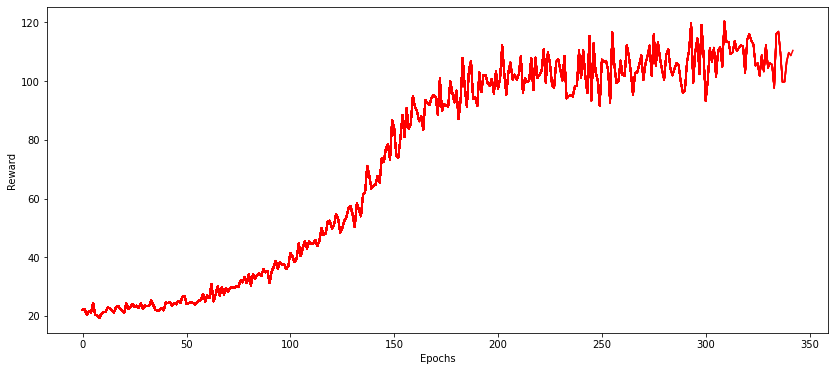

In [200]:
env = gym.make('CartPole-v0')
agent = Agent()
agent.train()
optimiser = optim.Adam(agent.parameters(), lr=1e-3)
discount = 0.999
epochs = 1000
rollouts = 100
total_rewards = []

plt.figure(figsize=(14, 6))
plt.xlabel('Epochs')
plt.ylabel('Reward')

# Converts numpy observations from the environment into a batch Tensor for PyTorch
def obs_to_tensor(obs):
    return torch.tensor(obs, dtype=torch.float32).unsqueeze(0)

def plot():
    plt.plot(range(len(total_rewards)), total_rewards, 'r-')
    clear_output(wait=True)
    display(plt.gcf())

for _ in range(epochs):
    optimiser.zero_grad()    
    total_reward = 0
    loss = 0
    for _ in range(rollouts):
        obs, done = obs_to_tensor(env.reset()), False
        log_probs_action, rewards = [], []  # Collect outputs for training
        while not done:
            # Sample an action from the policy conditioned on the current observation
            policy = agent(obs)
            action = policy.sample()
            # Take a step in the enviroment based on the action
            obs, reward, done, _ = env.step(action.item())
            obs = obs_to_tensor(obs)
            total_reward += reward

            # Store outputs that will be used for training
            rewards.append(reward)
            log_probs_action.append(policy.log_prob(action))
            

        # Initialise the final reward and generalised advantage at 0
        ep_return, gae = torch.zeros(1), torch.zeros(1)
        values.append(ep_return)
        trajectory_length = len(rewards)
        
        for i in reversed(range(trajectory_length)):  # Calculate the return backwards
            ep_return = rewards[i] + discount * ep_return  # Calculate the return recursively backwards
  
            loss -= log_probs_action[i] * ep_return  # Use the generalised advantage to weight the policy gradient

    loss.backward()  # Accumulate gradients
    optimiser.step()  # Perform batch update

    total_rewards.append(total_reward / rollouts)
    plot()

clear_output(wait=True)
display('Average final reward: %.2f' % total_rewards[-1])

'Average reward: 108.21'

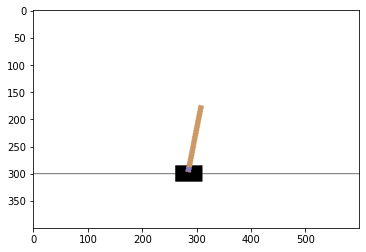

In [206]:
## Test

env.reset()
rollouts = 10
total_reward = 0
view = plt.imshow(env.render(mode='rgb_array'))

# Perform several rollouts/episodes with a random policy
for _ in range(rollouts):
    state, done = env.reset(), False  # Reset the environment to a starting state
    while not done:  # Act until episode terminates
        view.set_data(env.render(mode='rgb_array'))
        display(plt.gcf())
        clear_output(wait=True)
        policy = agent(obs_to_tensor(state))
        action = policy.sample()
        next_state, reward, done, _ = env.step(action.item())  # Sample random (valid) action
        total_reward += reward
        state=next_state

env.close()
display('Average reward: %.2f' % (total_reward / rollouts))